In [1]:
import pandas as pd
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam
import torch                    
import pyro
import pyro.distributions as dist
import numpy as np

/home/jpoulsen/anaconda3/envs/pyro/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dfranking = pd.read_csv("dfranking.csv")
dfplayerpergame = pd.read_csv("dfplayerpergame.csv")
dfgames = pd.read_csv("dfgames.csv")
dfgamebox = pd.read_csv("dfgamebox.csv")

In [3]:
S = dfgames["SEASON"].unique()
M = dfgames
GB = dfgamebox

In [4]:
np.unique(M["VISITOR_TEAM_ID"].values)

array([1610612737, 1610612738, 1610612739, 1610612740, 1610612741,
       1610612742, 1610612743, 1610612744, 1610612745, 1610612746,
       1610612747, 1610612748, 1610612749, 1610612750, 1610612751,
       1610612752, 1610612753, 1610612754, 1610612755, 1610612756,
       1610612757, 1610612758, 1610612759, 1610612760, 1610612761,
       1610612762, 1610612763, 1610612764, 1610612765, 1610612766])

In [5]:
#           #LAL        #GSW        #DEN      #PHX
teams = [1610612747, 1610612744, 1610612743, 1610612756]

In [6]:
M = M[(M["HOME_TEAM_ID"].isin(teams)) & (M["VISITOR_TEAM_ID"].isin(teams))]
GB = GB[GB["GAME_ID"].isin(M["GAME_ID"])]

In [7]:
GB["PTS"] = (GB["FG3M"]*3 + GB["FTM"] + (GB["FGM"]-GB["FG3M"])*2)

/tmp/ipykernel_31037/3819040321.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GB["PTS"] = (GB["FG3M"]*3 + GB["FTM"] + (GB["FGM"]-GB["FG3M"])*2)


In [8]:
dfplayerpergame["PTSPRMIN"] = (dfplayerpergame["FG3M"]*3 + dfplayerpergame["FTM"] + (dfplayerpergame["FGM"]-dfplayerpergame["FG3M"])*2) / dfplayerpergame["MIN"]
dfplayerpergame = dfplayerpergame.fillna(0)

In [9]:
dfplayerpergame.head()

,SEASON,PLAYER_NAME,POS,AGE,EXP,MIN,FGM,FGA,FG3M,FG3A,FTM,FTA,OREB,DREB,AST,STL,BLK,TO,PF,PTSPRMIN
0,2019,Aaron Gordon,PF,23.0,5.0,33.8,6.0,13.4,1.6,4.4,2.4,3.2,1.7,5.7,3.7,0.7,0.7,2.1,2.2,0.473373
1,2019,Aaron Holiday,PG,22.0,1.0,12.9,2.1,5.2,0.9,2.5,0.8,1.0,0.1,1.2,1.7,0.4,0.3,0.8,1.4,0.457364
2,2019,Aaron Nesmith,0,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,2019,Abdel Nader,SF,25.0,2.0,11.4,1.5,3.5,0.5,1.6,0.4,0.6,0.2,1.7,0.3,0.3,0.2,0.4,1.1,0.342105
4,2019,Adam Mokoka,0,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [10]:
M_dict = {s: M[M["SEASON"] == s] for s in S}
GB_dict = {s: {} for s in S}
Players_dict = {s: GB[GB["GAME_ID"].isin(M_dict[s]["GAME_ID"])]["PLAYER_NAME"].unique() for s in S}
for s in S:
    GB_dict[s] = {g: GB[GB["GAME_ID"] == g] for g in M[M["SEASON"] == s]["GAME_ID"].unique()}

In [11]:
playerpermin_dict = {s: [] for s in S}
for s in playerpermin_dict.keys():
    for p in Players_dict[s]:
        playerpermin_dict[s].append(dfplayerpergame[(dfplayerpergame["SEASON"] == s-1) & (dfplayerpergame["PLAYER_NAME"] == p)]["PTSPRMIN"].values[0] 
                     if len(dfplayerpergame[(dfplayerpergame["SEASON"] == s-1) & (dfplayerpergame["PLAYER_NAME"] == p)]["PTSPRMIN"]) > 0 else 0)

In [12]:
for key in playerpermin_dict:
    playerpermin_dict[key] = torch.tensor(playerpermin_dict[key])

numeric_feature_names = ['HOME_TEAM_WINS',"HOME_TEAM_WIN_PCT","AWAY_TEAM_WIN_PCT","HOME_TEAM_K","AWAY_TEAM_K"]
for key in M_dict:
    for feature in numeric_feature_names:
        M_dict[key].loc[:, feature] = torch.tensor(M_dict[key][feature].values).numpy()

numeric_feature_names = ['MIN', 'FGM', 'FGA', 'FG3M', 'FTM', 'FTA']
for key in GB_dict:
    for key2 in GB_dict[key]:
        for feature in numeric_feature_names:
            GB_dict[key][key2].loc[:, feature] = torch.tensor(GB_dict[key][key2][feature].values).numpy()


In [35]:
def model(S, M_dict, GB_dict, playerpermin, Players_dict,s):
    it=0

    #sigma = pyro.sample("sigma", dist.HalfCauchy(0.5))
    probs = []
    with pyro.plate(f'{s}_playerweights', len(Players_dict[s])):
            bias_p = pyro.sample(f"bias_{s}", dist.Normal(torch.zeros(len(Players_dict[s])), 1))
            w_p = pyro.sample(f"w_{s}", dist.Normal(torch.zeros(len(Players_dict[s])), 1))

    with pyro.plate(f'{s}_matches', len(M_dict[s])):

        #mu_ta = torch.tensor((M_dict[s]["HOME_TEAM_WIN_PCT"] + M_dict[s]["AWAY_TEAM_WIN_PCT"]).values,dtype=torch.float) #implement NN
        #mu_tb = torch.tensor((M_dict[s]["HOME_TEAM_WIN_PCT"] - M_dict[s]["AWAY_TEAM_WIN_PCT"]).values,dtype=torch.float)
        
        #sigma_tensor = sigma.expand_as(mu_ta)

        ka = pyro.sample(f"ka_{s}", dist.Normal(torch.zeros(len(M_dict[s])), 20*torch.ones(len(M_dict[s]))), obs=torch.from_numpy(M_dict[s]["HOME_TEAM_K"].values))
        kb = pyro.sample(f"kb_{s}", dist.Normal(torch.zeros(len(M_dict[s])), 20*torch.ones(len(M_dict[s]))), obs=torch.from_numpy(M_dict[s]["AWAY_TEAM_K"].values))
        
    
    for idx,m in enumerate(M_dict[s].iterrows()):
        game_id = m[1]["GAME_ID"]
        GB = GB_dict[s][game_id]
        players_ta = set(GB[GB["TEAM_ID"] == m[1]["HOME_TEAM_ID"]]["PLAYER_NAME"])
        players_tb = set(GB[GB["TEAM_ID"] == m[1]["VISITOR_TEAM_ID"]]["PLAYER_NAME"])
        players_idx_ta = [i for i, value in enumerate(Players_dict[s]) if value in players_ta]
        players_idx_tb = [i for i, value in enumerate(Players_dict[s]) if value in players_tb]
        #print(GB[GB["TEAM_ID"] == m[1]["HOME_TEAM_ID"]]["PLAYER_NAME"].values)
        #print(players_ta)
        #GB_ta_idx = [np.where(GB["PLAYER_NAME"] == i)[0][0] for i in players_ta]
        #GB_tb_idx = [np.where(GB["PLAYER_NAME"] == i)[0][0] for i in players_tb]
        GB_ta_idx = np.where(GB["TEAM_ID"] == m[1]["HOME_TEAM_ID"])
        GB_tb_idx = np.where(GB["TEAM_ID"] == m[1]["VISITOR_TEAM_ID"])
        with pyro.plate(f'{game_id}_box_ta', len(GB_ta_idx[0])): #
                mins_ta = pyro.sample(f'mins_{s}_{game_id}_ta', dist.Normal(bias_p[players_idx_ta] + w_p[players_idx_ta] *ka[idx], torch.ones(len(GB_ta_idx[0]))), obs=torch.from_numpy(GB.iloc[GB_ta_idx]["MIN"].values))
                pts_ta = pyro.sample(f'pts_{s}_{game_id}_ta', dist.Poisson(torch.exp(mins_ta * torch.tensor(playerpermin_dict[s][players_idx_ta]))), 
                                    obs = torch.from_numpy(GB.iloc[GB_ta_idx]["PTS"].values))

        with pyro.plate(f'{game_id}_box_tb', len(GB_tb_idx[0])): #
                mins_tb = pyro.sample(f'mins_{s}_{game_id}_tb', dist.Normal(bias_p[players_idx_tb] + w_p[players_idx_tb] *kb[idx], torch.ones(len(GB_tb_idx[0]))), obs=torch.from_numpy(GB.iloc[GB_tb_idx]["MIN"].values))
                pts_tb = pyro.sample(f'pts_{s}_{game_id}_tb', dist.Poisson(torch.exp(mins_tb * torch.tensor(playerpermin_dict[s][players_idx_tb]))), 
                                    obs = torch.from_numpy(GB.iloc[GB_tb_idx]["PTS"].values))

        Pts_ta = torch.sum(pts_ta)
        Pts_tb = torch.sum(pts_tb)

        P_ta_gt_tb = Pts_ta / (Pts_ta + Pts_tb)
        probs.append(P_ta_gt_tb)
    return probs


In [36]:
# Run inference in Pyro
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=70, warmup_steps=10, num_chains=1)
mcmc.run(S, M_dict, GB_dict, playerpermin_dict, Players_dict,2020)

# Show summary of inference results
mcmc.summary()

Warmup:   0%|          | 0/80 [00:00, ?it/s]/tmp/ipykernel_31037/2735485520.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pts_ta = pyro.sample(f'pts_{s}_{game_id}_ta', dist.Poisson(torch.exp(mins_ta * torch.tensor(playerpermin_dict[s][players_idx_ta]))),
/tmp/ipykernel_31037/2735485520.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pts_tb = pyro.sample(f'pts_{s}_{game_id}_tb', dist.Poisson(torch.exp(mins_tb * torch.tensor(playerpermin_dict[s][players_idx_tb]))),
Sample:  26%|██▋       | 21/80 [07:05, 69.57s/it, step size=4.05e-03, acc. prob=0.380]

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

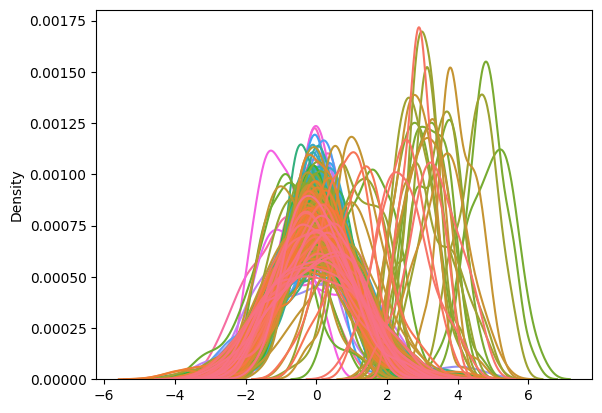

In [ ]:
# Extract samples from posterior
posterior_samples = mcmc.get_samples()

sns.kdeplot(posterior_samples["bias_2022"])
plt.legend([],[], frameon=False)
#sns.kdeplot(posterior_samples["w_2022"])


In [ ]:
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam

In [14]:
# Define guide function
guide = AutoMultivariateNormal(model)

# Reset parameter values
pyro.clear_param_store()

n_steps = 4000

# Setup the optimizer
adam_params = {"lr": 0.001} # learning rate (lr) of optimizer
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(model, guide, optimizer, loss=elbo)



In [15]:
# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(S, M_dict, GB_dict, playerpermin_dict, Players_dict,2022)
    if step % 100 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

/tmp/ipykernel_31037/3178148903.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pts_ta = pyro.sample(f'pts_{s}_{game_id}_ta', dist.Poisson(torch.exp(mins_ta * torch.tensor(playerpermin_dict[s][players_idx_ta]))),
/tmp/ipykernel_31037/3178148903.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pts_tb = pyro.sample(f'pts_{s}_{game_id}_tb', dist.Poisson(torch.exp(mins_tb * torch.tensor(playerpermin_dict[s][players_idx_tb]))),


[0] ELBO: 924309044378948848916103168.0
[100] ELBO: 716211233531934413426786304.0
[200] ELBO: 492644918588885578517839872.0
[300] ELBO: 495219246611272928499597312.0
[400] ELBO: 112736088227439254318350336.0
[500] ELBO: 121366554272676351265734656.0
[600] ELBO: 56340457028620653984481280.0
[700] ELBO: 94531193005946059725209600.0
[800] ELBO: 21671239468743543738073088.0
[900] ELBO: 29844411537841059446915072.0
[1000] ELBO: 27587032170771076347854848.0
[1100] ELBO: 17942616674842700551290880.0
[1200] ELBO: 6216378027540502716350464.0
[1300] ELBO: 12423876682405573067538432.0
[1400] ELBO: 11251491973188400801906688.0
[1500] ELBO: 6897993700720966392348672.0
[1600] ELBO: 4903366222092433073635328.0
[1700] ELBO: 8148395894623900086042624.0
[1800] ELBO: 4758569497900270705704960.0
[1900] ELBO: 1886113958728455432437760.0
[2000] ELBO: 6591450380989332600127488.0
[2100] ELBO: 3196959973814605851918336.0
[2200] ELBO: 1638443421238076073050112.0
[2300] ELBO: 3086463612911393316012032.0
[2400] E

In [16]:
from pyro.infer import Predictive

predictive = Predictive(model, guide=guide, num_samples=1000,
                        return_sites=("bias_2022","w_2022", "ka_2022","kb_2022"))
samples = predictive(S, M_dict, GB_dict, playerpermin_dict, Players_dict,2022)

/tmp/ipykernel_31037/3178148903.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pts_ta = pyro.sample(f'pts_{s}_{game_id}_ta', dist.Poisson(torch.exp(mins_ta * torch.tensor(playerpermin_dict[s][players_idx_ta]))),
/tmp/ipykernel_31037/3178148903.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pts_tb = pyro.sample(f'pts_{s}_{game_id}_tb', dist.Poisson(torch.exp(mins_tb * torch.tensor(playerpermin_dict[s][players_idx_tb]))),


In [17]:
bias_samples = samples["bias_2022"].detach().numpy()
w_samples = samples["w_2022"].detach().numpy()
ka_samples = samples["ka_2022"].detach().numpy()
kb_samples = samples["kb_2022"].detach().numpy()

In [20]:
import matplotlib.pyplot as plt

In [31]:
import seaborn as sns

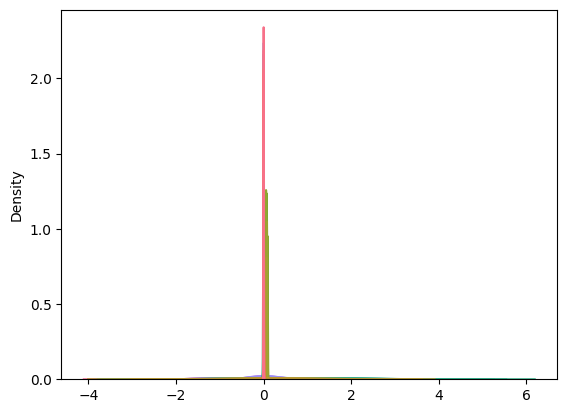

In [34]:
sns.kdeplot(w_samples)
plt.legend([],[], frameon=False)

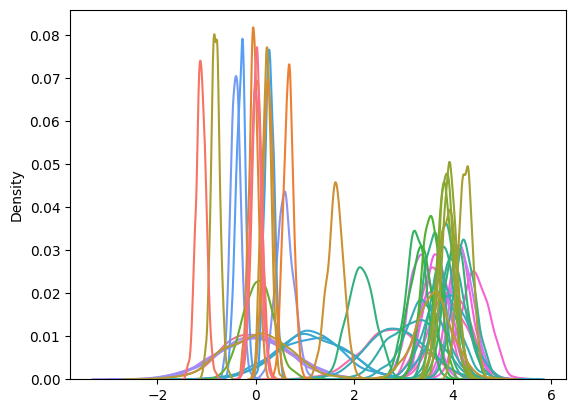

In [33]:
sns.kdeplot(bias_samples)
plt.legend([],[], frameon=False)

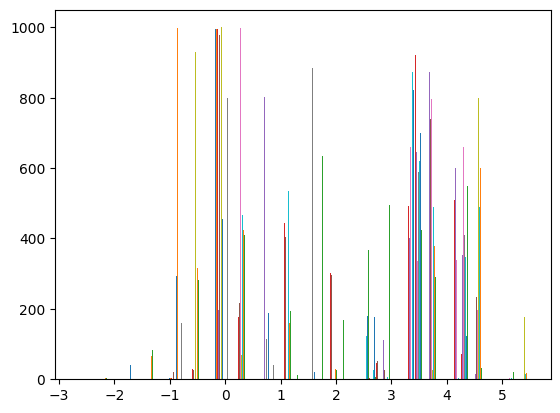

In [29]:
# Create histogram
plt.hist(bias_samples, bins=10)

# Show plot
plt.show()